In [2]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage
#from lr_utils import load_dataset
import pandas as pd
from sklearn.cluster import KMeans

In [3]:
get_ipython().magic('matplotlib inline')

In [4]:
def load_dataset():
    train_dataset = h5py.File('datasets/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('datasets/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [11]:
#Loading the data set

train_set_x_orig,train_set_y,test_set_x_orig,test_set_y,classes = load_dataset()
#print(train_set_x_orig)
#print(train_set_y)
#print(test_set_x_orig)
#print(test_set_y)
#print(classes)
print(train_set_x_orig.shape)
print(train_set_y.shape)
print(test_set_x_orig.shape)
print(test_set_y.shape)


(209, 64, 64, 3)
(1, 209)
(50, 64, 64, 3)
(1, 50)


In [12]:
m_train = train_set_y.shape[1] #num of training examples = 209
m_test = test_set_y.shape[1] #num  of test examples = 50
num_px = train_set_x_orig.shape[1] #num of pixels = 64

In [15]:
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0],-1).T
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0],-1).T
print(train_set_x_flatten.shape)
print(test_set_x_flatten.shape)

(12288, 209)
(12288, 50)


In [18]:
train_set_x = train_set_x_flatten / 255
test_set_x = train_set_x_flatten / 255
print(train_set_x.shape)
print(test_set_x.shape)

(12288, 209)
(12288, 209)


In [19]:
def sigmoid(z):
    s = 1 / (1 + np.exp(-z))
    return s

In [20]:
def initialize_with_zeros(dim):
    w = np.zeros(shape=(dim,1))
    b = 0
    
    assert(w.shape == (dim,1))
    assert(isinstance(b,float) or isinstance(b,int))
    return w,b

In [21]:
def propagate(w,b,X,Y):
    m = X.shape[1]
    
    #forward propagation -- from X to COST
    
    A = sigmoid(np.dot(w.T,X)+b) #compute activation
    cost = (-1/m) * np.sum(Y * np.log(A) + (1-Y) * (np.log(1-A))) #compute cost
    
    #Backward Propagation -- to find grad
    dw = (1/m)*np.dot(X,(A-Y).T)
    db = (1/m)*np.sum(A-Y)
    
    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    grads = {"dw":dw,"db":db}
    return grads,cost

In [22]:
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):

    
    costs = []
    
    for i in range(num_iterations):
        
        
        # Cost and gradient calculation 
       
        grads, cost = propagate(w, b, X, Y)
      
        
        # Retrieve derivatives from grads
        dw = grads["dw"]
        db = grads["db"]
        
        # update rule 
      
        w = w - learning_rate * dw  # need to broadcast
        b = b - learning_rate * db
     
        
        # Record the costs
        if i % 100 == 0:
            costs.append(cost)
        
        # Print the cost every 100 training examples
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" % (i, cost))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

In [23]:
def predict(w,b,X):
    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    w = w.reshape(X.shape[0],1)
    
    # Compute vector "A" predicting the probabilities of a cat being present in the picture
    A =sigmoid(np.dot(w.T,X) + b)
    
    for i in range(A.shape[1]):
        # Convert probabilities a[0,i] to actual predictions p[0,i]
        Y_prediction[0,i] = 1 if A[0,i] >0.5 else  0
    assert(Y_prediction.shape == (1,m))
    
    return Y_prediction
    

In [40]:
def model(X_train,Y_train,X_test,Y_test,num_iterations=2000,learning_rate=0.5,print_cost=False):
    w,b = initialize_with_zeros(X_train.shape[0])
    parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)
     # Retrieve parameters w and b from dictionary "parameters"
    w = parameters["w"]
    b = parameters["b"]
    
    # Predict test/train set examples
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)

  

    # Print train/test Errors
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    #print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

In [41]:
d = model(train_set_x,train_set_y,test_set_x,test_set_y,num_iterations=2000,learning_rate=0.005,print_cost=True)

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.584508
Cost after iteration 200: 0.466949
Cost after iteration 300: 0.376007
Cost after iteration 400: 0.331463
Cost after iteration 500: 0.303273
Cost after iteration 600: 0.279880
Cost after iteration 700: 0.260042
Cost after iteration 800: 0.242941
Cost after iteration 900: 0.228004
Cost after iteration 1000: 0.214820
Cost after iteration 1100: 0.203078
Cost after iteration 1200: 0.192544
Cost after iteration 1300: 0.183033
Cost after iteration 1400: 0.174399
Cost after iteration 1500: 0.166521
Cost after iteration 1600: 0.159305
Cost after iteration 1700: 0.152667
Cost after iteration 1800: 0.146542
Cost after iteration 1900: 0.140872
train accuracy: 99.04306220095694 %


y = 0.0, your algorithm predicts a "non-cat" picture.


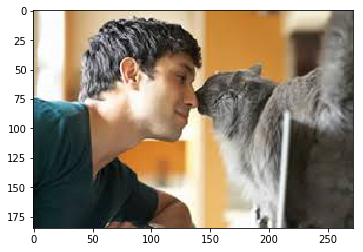

In [37]:
my_image = "hum_cat2.jpg"   # change this to the name of your image file 


#preprocess the image to fit your algorithm.
fname = "images/" + my_image
image = np.array(ndimage.imread(fname, flatten=False))
my_image = scipy.misc.imresize(image, size=(num_px, num_px)).reshape((1, num_px * num_px * 3)).T
my_predicted_image = predict(d["w"], d["b"], my_image)

plt.imshow(image)
print("y = " + str(np.squeeze(my_predicted_image)) + ", your algorithm predicts a \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")

